In [1]:
import cv2
import numpy as np
import os
import pickle
from matplotlib import pyplot as plt


[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 254 255 255 255 255 255 255 255 255 248 188 166 224 255]
 [255 255 255 255 255 255 255 255 255 151  19   0   1  22  95]
 [254 255 255 254 255 255 255 255 188   1   0  23  65  70  70]
 [255 255 255 255 255 255 255 254  75   0  20  71  68  68  70]
 [255 255 255 255 255 254 255 252   9   0  58  70  70  70  72]
 [255 255 255 255 255 255 255 222   0   2  70  73  70  70  70]
 [255 255 255 255 255 255 255 213   2   0  67  68  70  70  70]
 [255 255 255 255 255 255 255 228   0   0  59  72  70  70  70]
 [255 255 255 255 255 255 255 253  18   0  50  70  70  70  70]
 [255 255 255 255 255 255 255 255  54   0  10  65  70  70  67]
 [255 255 255 255 255 255 255 253  21   0   0   4  22  

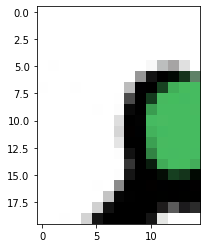

In [2]:
img = cv2.imread(os.path.join("endpt_dataset/endpt_imgs", "1.jpeg"))
# print(img.shape)
img = img[355:375, 360:375]
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_red = img[:, :, 0]
img_green = img[:, :, 1]
img_blue = img[:, :, 2]
# img[:, :, 0] = img[:, :, 2]
# img[:, :, 2] = img_blue
plt.imshow(img)
print(img_red, "\n\n")
print(img_green, "\n\n")
print(img_blue, "\n\n")
print(img_gray, "\n\n")
# print(img.reshape((18, 18)))

In [ ]:
with open('processed_images.pickle', 'rb') as f:
    processed_images = pickle.load(f)
processed_images, len(processed_images)

In [ ]:
with open('window_labels.pickle', 'rb') as f:
    window_labels = pickle.load(f)
window_labels

        

In [4]:
def load_images_from_folder(folder):
    image_tuples = []
    for filename in os.listdir(folder):
        if (filename not in processed_images):
            img = cv2.imread(os.path.join(folder,filename))
            if (img is not None):
                image_tuples.append((filename, img))
    return image_tuples

In [5]:
# MinMax Scaler
def minmaxScaler(image):
    minPixel = np.amin(image)
    maxPixel = np.amax(image)
    image = (image - minPixel) / (maxPixel - minPixel)
    return image

In [6]:
def threshold_image(image, threshold=0.1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = minmaxScaler(gray)
    for i in range(len(gray)):
        for j in range(len(gray[i])):
            gray[i][j] = int((gray[i][j] > threshold) and not (image[i][j][0] < 255 * (1 - threshold) and image[i][j][1] < 255 * (1 - threshold) and image[i][j][2] > 255 * threshold)) * 255
    return gray
def threshold_image_green(image, threshold=0.1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = minmaxScaler(gray)
    for i in range(len(gray)):
        for j in range(len(gray[i])):
            gray[i][j] = int((gray[i][j] > threshold) and not (image[i][j][0] < 255 * (1 - threshold) and image[i][j][1] > 255 * threshold and image[i][j][2] < 255 * (1 - threshold)) and not (image[i][j][0] < 255 * (1 - threshold) and image[i][j][1] < 255 * (1 - threshold) and image[i][j][2] > 255 * threshold)) * 255
    return gray

In [7]:
def generate_windows(image, filename, window_size, interior_size, increment, folder):
    gray_img = threshold_image_green(image)
    x = 0
#     the_counter = 0
    while (x < image.shape[0] - window_size):
        row_has_intersection = False
        y = 0
        while (y < image.shape[1] - window_size):

            window = image[x : x + window_size, y : y + window_size, :]
#             if (counter < 10):
#                 print(window.shape)
#                 print(window[10:30, 10:30, 0])
#                 print(window[10:30, 10:30, 1])
#                 print(window[10:30, 10:30, 2])
            has_intersection = False
            
            gray = gray_img[x : x + window_size, y : y + window_size]
            sum_of_grayscale_pixels = np.sum(gray) / 255
            
            
            # if the image is not completely white, we can add it to the dataset
            if (sum_of_grayscale_pixels < window_size * window_size) and sum_of_grayscale_pixels >= window_size * window_size/10:
                
                # check center interior square for any red pixels
                for x_interior in range (int(window_size/2 - interior_size/2), int(window_size/2 + interior_size/2)):
                    for y_interior in range (int(window_size/2 - interior_size/2), int(window_size/2 + interior_size/2)): 
                        # check if pixel is red
#                         if (not has_intersection and 
#                             window[x_interior][y_interior][0] < 100 and 
#                             window[x_interior][y_interior][1] < 100 and
#                             window[x_interior][y_interior][2] > 200):
                        if (not has_intersection and 
                            window[x_interior][y_interior][0] < 100 and 
                            window[x_interior][y_interior][1] > 150 and
                            window[x_interior][y_interior][2] < 100):
                            row_has_intersection = True
                            has_intersection = True
#                             if counter > 100 and counter < 120:
#                                 print("------------------------------")
#                                 print(window[int(window_size/2 - interior_size/2):int(window_size/2 + interior_size/2), int(window_size/2 - interior_size/2):int(window_size/2 + interior_size/2), 0])
#                                 print(window[int(window_size/2 - interior_size/2):int(window_size/2 + interior_size/2), int(window_size/2 - interior_size/2):int(window_size/2 + interior_size/2), 1])
#                                 print(window[int(window_size/2 - interior_size/2):int(window_size/2 + interior_size/2), int(window_size/2 - interior_size/2):int(window_size/2 + interior_size/2), 2])
#                                 plt.figure()
#                                 plt.imshow(window)
#                             counter += 1
                            
#             if (the_counter < 10 and has_intersection):
#                 print(f"-------------------{the_counter}------------------ \n\n")
#                 print(window.shape)
#                 print(window[5:20, 5:20, 0], "\n\n")
#                 print(window[5:20, 5:20, 1], "\n\n")
#                 print(window[5:20, 5:20, 2])
#                 plt.figure()
#                 plt.imshow(window)
#                 the_counter += 1
                window_id = str(x) + "_" + str(y) + "_" + str(int(has_intersection)) + "_" + filename
                window_labels[window_id] = int(has_intersection)
                cv2.imwrite(os.path.join(folder, window_id), gray)
                
            if (has_intersection):
                y += int(increment / 5)
            else:
                y += increment
        if (row_has_intersection):
            x += int(increment / 5)
        else:
            x += increment

    processed_images.append(filename)

In [8]:
# image_tuples = load_images_from_folder("test_images")
image_tuples = load_images_from_folder("endpt_dataset/Images")
print("The length is ", len(image_tuples))
for image_tuple in image_tuples:
    filename = image_tuple[0]
    image = image_tuple[1]
    generate_windows(image=image, filename=filename, window_size=25, interior_size=5, increment=10, folder="endpt_dataset/window_images")
#     generate_windows(image=image, filename=filename, window_size=25, interior_size=5, increment=2, folder="test_mini_images")

The length is  238


In [ ]:
with open('processed_images.pickle', 'wb') as f:
    pickle.dump(processed_images, f)

In [ ]:
with open('window_labels.pickle', 'wb') as f:
    pickle.dump(window_labels, f)

In [3]:
processed_images = []
window_labels = {}

In [9]:
# plt.figure()
counter = 0

for label in window_labels:
    if (counter < 2):
        print("doesn't work", label)
    if window_labels[label]:
        if (counter < 20):
            print(label)
        counter += 1
    
#         img = cv2.imread(os.path.join("endpt_dataset/window_images", label))
#         plt.imshow(img)
        
print(len(window_labels))
print(counter)

doesn't work 80_160_0_236.jpeg
doesn't work 80_170_0_236.jpeg
doesn't work 90_150_0_236.jpeg
doesn't work 90_160_0_236.jpeg
doesn't work 90_170_0_236.jpeg
doesn't work 90_180_0_236.jpeg
doesn't work 100_150_0_236.jpeg
doesn't work 100_160_0_236.jpeg
doesn't work 100_170_0_236.jpeg
doesn't work 100_180_0_236.jpeg
doesn't work 100_250_0_236.jpeg
doesn't work 100_260_0_236.jpeg
doesn't work 100_270_0_236.jpeg
doesn't work 110_150_0_236.jpeg
doesn't work 110_160_0_236.jpeg
doesn't work 110_170_0_236.jpeg
doesn't work 110_180_0_236.jpeg
doesn't work 110_250_0_236.jpeg
doesn't work 110_260_1_236.jpeg
110_260_1_236.jpeg
doesn't work 110_262_1_236.jpeg
110_262_1_236.jpeg
110_264_1_236.jpeg
110_266_1_236.jpeg
112_260_1_236.jpeg
112_262_1_236.jpeg
112_264_1_236.jpeg
112_266_1_236.jpeg
114_260_1_236.jpeg
114_262_1_236.jpeg
114_264_1_236.jpeg
114_266_1_236.jpeg
136_430_1_236.jpeg
136_432_1_236.jpeg
136_434_1_236.jpeg
136_436_1_236.jpeg
136_438_1_236.jpeg
138_430_1_236.jpeg
138_432_1_236.jpeg
138_4

In [ ]:
print(len(processed_images))
processed_images

In [ ]:
import shutil
def new_threshold(gray, threshold=25):
    for i in range(len(gray)):
        for j in range(len(gray[i])):
            gray[i][j] = int(gray[i][j] > threshold) * 255
    return gray
directory = "test_mini_images"
# new_directory = "test"
counter = 0
new_counter = 0
for filename in os.listdir(directory):
#     print(filename, directory, os.path.join(directory, filename))
#     if counter < 100:
#         print(filename)
#     if counter > 30000:
#         break
    img = cv2.imread(os.path.join(directory,filename), 0)
    img = new_threshold(img)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    counter += 1
    if np.sum(img)/255 < 60:
        new_counter += 1
#         shutil.move(os.path.join(directory, filename), os.path.join(new_directory, filename))

print(counter, new_counter)
        
